In [146]:
import pandas as pd
import joblib
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.metrics import accuracy_score, precision_score
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
# Путь к папке с изображениями
images_folder = "/Users/aleksey/PycharmProjects/MediScan/Aleksey/ISIC2018_Task3_Training_Input"

# Получаем список файлов изображений в папке
image_files = [f for f in os.listdir(images_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

# Инициализация массива для одномерных векторов
image_vectors = []

# Проход по каждому изображению
for image_file in tqdm(image_files):
    # Загрузка изображения
    image_path = os.path.join(images_folder, image_file)
    image = imread(image_path, as_gray=True)
    
    image = rescale(image, 0.2, anti_aliasing=False)
    # img_hog, hog_img = hog(
    # image, pixels_per_cell=(14,14), 
    # cells_per_block=(2, 2), 
    # orientations=10, 
    # visualize=True, 
    # block_norm='L2-Hys')
    image_vectors.append(image)

image_vectors_array = np.array(image_vectors)

# pca = PCA(n_components=10)
# pca.fit(image_vectors_array)
# image_vectors_array = pca.transform(image_vectors_array)

class_dict = {"MEL": 1, "NV": 2, "BCC": 3, "AKIEC": 4, "BKL":5, "DF": 6, "VASC": 7}
results = pd.read_csv("/Users/aleksey/PycharmProjects/MediScan/Aleksey/ISIC2018_Task3_Training_GroundTruth.csv")
res_labels = results.drop("image", axis=1)
decoded_labels = res_labels.apply(lambda row: row.idxmax(), axis=1)
results['class'] = decoded_labels
results = results[["image","class"]]
results["image"] = results["image"] + ".jpg"
columns = [f"Pixel_{i}" for i in range(image_vectors_array.shape[1])]
df = pd.DataFrame(data=image_vectors_array, columns=columns)
df['image'] = image_files
data = pd.merge(df, results, on="image")
data["class"] = data["class"].replace(class_dict)
X_train = data.drop(["image", "class"], axis=1)
y_train = data["class"]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)


# Путь к папке с изображениями
images_folder = "/Users/aleksey/PycharmProjects/MediScan/Aleksey/ISIC2018_Task3_Test_Input"

# Получаем список файлов изображений в папке
image_files = [f for f in os.listdir(images_folder) if f.endswith(('jpg', 'jpeg', 'png'))]

# Инициализация массива для одномерных векторов
image_vectors = []

# Проход по каждому изображению
for image_file in tqdm(image_files):
    # Загрузка изображения
    image_path = os.path.join(images_folder, image_file)
    image = imread(image_path, as_gray=True)
    
    image = rescale(image, 0.2, anti_aliasing=False)
    # img_hog, hog_img = hog(
    # image, pixels_per_cell=(14,14), 
    # cells_per_block=(2, 2), 
    # orientations=10, 
    # visualize=True, 
    # block_norm='L2-Hys')
    flat_vector = np.array(image).flatten()
    image_vectors.append(flat_vector)

image_vectors_array = np.array(image_vectors)
# image_vectors_array = pca.transform(image_vectors_array)
columns = [f"Pixel_{i}" for i in range(image_vectors_array.shape[1])]
df = pd.DataFrame(data=image_vectors_array, columns=columns)
df['image'] = image_files
results = pd.read_csv("/Users/aleksey/PycharmProjects/MediScan/Aleksey/ISIC2018_Task3_Test_GroundTruth.csv")
res_labels = results.drop("image", axis=1)
decoded_labels = res_labels.apply(lambda row: row.idxmax(), axis=1)
results['class'] = decoded_labels
results = results[["image","class"]]
results["image"] = results["image"] + ".jpg"
data = pd.merge(df, results, on="image")
data["class"] = data["class"].replace(class_dict)
X_test = data.drop(["image", "class"], axis=1)
y_test = data["class"]
X_test = scaler.transform(X_test)

100%|██████████| 1512/1512 [00:10<00:00, 138.34it/s]


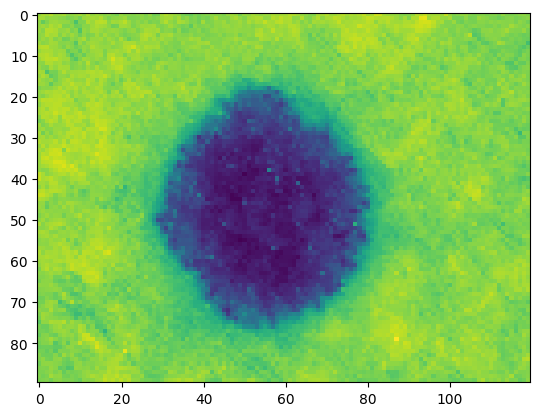

In [147]:
plt.imshow(image)

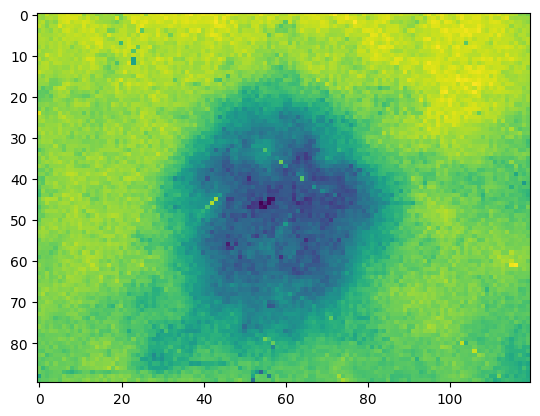

In [148]:

image = imread("/Users/aleksey/PycharmProjects/MediScan/Aleksey/ISIC_0034351.jpg", as_gray=True)
image = rescale(image, 0.2, anti_aliasing=False)
plt.imshow(image)

In [150]:
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.model_selection import GridSearchCV
lr_cls = RidgeClassifier()
parameters = {'alpha': [1,2,3,4,5,20,40,50,100, 200, 300, 400, 500, 1000, 2000, 5000, 10000, 20000, 40000, 50000]}
grid_search = GridSearchCV(estimator = lr_cls,  
                           param_grid = parameters,
                           scoring="r2",
                           cv = 5)


grd = grid_search.fit(X_train, y_train)  
print("tuned hpyerparameters :(best parameters) ",grd.best_params_)
print("accuracy :",grd.best_score_)

tuned hpyerparameters :(best parameters)  {'alpha': 40000}
accuracy : -0.14231749384522274


In [152]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, r2_score

# lr_cls = LogisticRegression(max_iter=10000, tol=0.0001)
# lr_cls.fit(X_train, y_train)  
predictions = grd.predict(X_test)
print("{:.2%}".format(r2_score(y_test, predictions)))

-22.88%


In [129]:
predictions

array([2, 2, 2, ..., 1, 2, 2])

In [8]:
joblib.dump(lr_cls, '/Users/aleksey/PycharmProjects/MediScan/Aleksey/MVP model/sgd_model.pkl')
joblib.dump(pca, '/Users/aleksey/PycharmProjects/MediScan/Aleksey/MVP model/pca.pkl')
joblib.dump(scaler, '/Users/aleksey/PycharmProjects/MediScan/Aleksey/MVP model/sc.pkl')

['/Users/aleksey/PycharmProjects/MediScan/Aleksey/MVP model/sc.pkl']

In [9]:
model = joblib.load("sgd_model.pkl")
pca = joblib.load("pca.pkl")

In [16]:
predictions = model.predict(X_test)
print("{:.2%}".format(accuracy_score(y_test, predictions)))

60.12%
